In [1]:
!pip install --quiet git+https://github.com/EgorDudyrev/paspailleur.git
import caspailleur as csp
from paspailleur import pattern_structures as PS

In [2]:
from importlib import reload

In [3]:
from script import clustering as clib, visual_lib as vlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from functools import reduce
from bitarray import frozenbitarray

# Test examples on Circles data

## Step 1. Get the data

In [5]:
from sklearn import datasets

n_samples = 500
seed = 30

In [6]:
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)
X, y = blobs

## Step 2. Setup pattern structures
For numerical columns, setup the grid of intervals that is not too general and not too precise

In [7]:
linscale_x = np.linspace(X[:,0].min()-0.01, X[:,0].max()+0.01, 11)
linscale_y = np.linspace(X[:,1].min()-0.01, X[:,1].max()+0.01, 11)

ps = PS.CartesianPS([PS.IntervalPS(values=linscale_x), PS.IntervalPS(values=linscale_y)])
data = list(ps.preprocess_data(X))

## Step 3. Mine stable concepts
Stable concepts are individual clusters of similar (but not too much) objects 

In [8]:
min_cluster_support = 10
min_delta_stability = 5
print(f"{min_cluster_support/len(data)=}, {min_delta_stability/len(data)=}")

min_cluster_support/len(data)=0.02, min_delta_stability/len(data)=0.01


In [9]:
min_added_coverage = 75
min_cluster_support = max(min_cluster_support, min_added_coverage)
print(f"{min_added_coverage/len(data)=}")

min_added_coverage/len(data)=0.15


In [10]:
attributes, attr_extents = zip(*ps.iter_attributes(data, min_support=min_cluster_support))
print(len(attributes))

31


In [11]:
%%time
stable_extents = csp.mine_equivalence_classes.list_stable_extents_via_gsofia(
    attr_extents,
    n_objects=len(data), min_delta_stability=min_delta_stability, min_supp=min_cluster_support,
    use_tqdm=True, n_attributes=len(attributes)
)
stable_extents = sorted(stable_extents, key=lambda ext: ext.count(), reverse=True)
print(f"n extents", len(stable_extents))

  0%|          | 0/31 [00:00<?, ?it/s]

n extents 504
CPU times: user 19.8 ms, sys: 11.7 ms, total: 31.5 ms
Wall time: 30.8 ms


### Step 4. Find all minimal covering clusterings

In [12]:
n_clusters_max = 4
jaccard_thold = 1 # 0.9
min_total_coverage = 450
print(f"{min_total_coverage/len(data)=}")

min_total_coverage/len(data)=0.9


Filter out too similar clusters to simplify the search space (if having too many concepts)

In [13]:
sparse_extents = clib.select_sparse_extents(stable_extents, jaccard_thold)
print(f"{len(stable_extents)=}", f"{len(sparse_extents)=}")

len(stable_extents)=504 len(sparse_extents)=504


Find the a lot of minimal clusterings

In [14]:
%%time
clusterings = list(clib.mine_clusterings(
    sparse_extents,
    min_support=min_total_coverage, max_length=n_clusters_max, min_added_coverage=min_added_coverage
))
print('n clusterings:', len(clusterings))
print('max found cluster size', max(map(len, clusterings)))

n clusterings: 68579
max found cluster size 4
CPU times: user 26.6 s, sys: 178 ms, total: 26.7 s
Wall time: 26.7 s


## Step 5. Choose the "optimal" clustering

In [15]:
clib = reload(clib)

In [16]:
concepts_dict = clib.mine_clusters_info(sparse_extents, attr_extents, ps, data)
concepts_df = pd.DataFrame(concepts_dict)
concepts_df.head()

,extent,intent,delta_stability,support,frequency,intent_human,level,density
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","((-0.03, 12.42, (BoundStatus.RCLOSED, BoundSta...",6,498,0.996,"x0: [-0.03, 12.42], x1: [-9.27, 0.08]",1,4.278075
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","((-0.03, 11.17, (BoundStatus.RCLOSED, BoundSta...",10,492,0.984,"x0: [-0.03, 11.17], x1: [-9.27, 0.08]",2,4.698243
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","((-0.03, 12.42, (BoundStatus.RCLOSED, BoundSta...",6,488,0.976,"x0: [-0.03, 12.42], x1: [-8.23, 0.08]",1,4.716822
3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","((1.21, 12.42, (BoundStatus.RCLOSED, BoundStat...",6,487,0.974,"x0: [1.21, 12.42], x1: [-9.27, 0.08]",2,4.646348
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","((-0.03, 11.17, (BoundStatus.RCLOSED, BoundSta...",10,482,0.964,"x0: [-0.03, 11.17], x1: [-8.23, 0.08]",2,5.178786


In [17]:
clusterings_df = pd.DataFrame([clib.evaluate_clustering_measures(idxs, concepts_dict) for idxs in clusterings],
                              index=pd.Series(clusterings, name='clustering'))
clusterings_df.head()

,coverage,overlap,size,imbalance,stability,complexity,density
clustering,,,,,,,
"(0,)",498,0,1,0.0,6.0,1.0,4.278075
"(1,)",492,0,1,0.0,10.0,2.0,4.698243
"(2,)",488,0,1,0.0,6.0,1.0,4.716822
"(3,)",487,0,1,0.0,6.0,2.0,4.646348
"(4,)",482,0,1,0.0,10.0,2.0,5.178786


In [18]:
clusterings_df_norm = (clusterings_df-clusterings_df.min())/(clusterings_df.max()-clusterings_df.min())
clusterings_df_norm.describe().loc[['min', 'max']]

,coverage,overlap,size,imbalance,stability,complexity,density
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [19]:
weight_params = dict(
    overlap_weight=2,
    size_weight=0.1, # old "n_concepts_weight"
    imbalance_weight=2,
    stability_weight=1,
    complexity_weight=0.1,
    density_weight=5
)

signs = np.array([1 if f in {'coverage', 'stability', 'density'} else -1 for f in clusterings_df_norm])
weights = np.array([1 if f == 'coverage' else weight_params[f"{f}_weight"] for f in clusterings_df_norm])
clusterings_df['reward'] = (clusterings_df_norm*weights*signs).sum(1)

In [20]:
clusterings_df = clusterings_df.sort_values('reward', ascending=False)
clusterings_df.head()

,coverage,overlap,size,imbalance,stability,complexity,density,reward
clustering,,,,,,,,
"(268, 337, 425)",458,0,3,42.500980,17.333333,2.0,10.797780,4.408739
"(295, 459, 462, 478)",456,0,4,46.783188,18.000000,2.0,10.847742,4.345850
"(322, 337, 361)",458,0,3,9.504385,19.000000,2.0,10.161632,4.315831
"(295, 462, 472, 478)",451,0,4,47.591141,18.500000,2.0,10.912313,4.287620
"(320, 374, 425, 452)",453,59,4,31.123410,20.250000,2.0,10.984990,4.252022


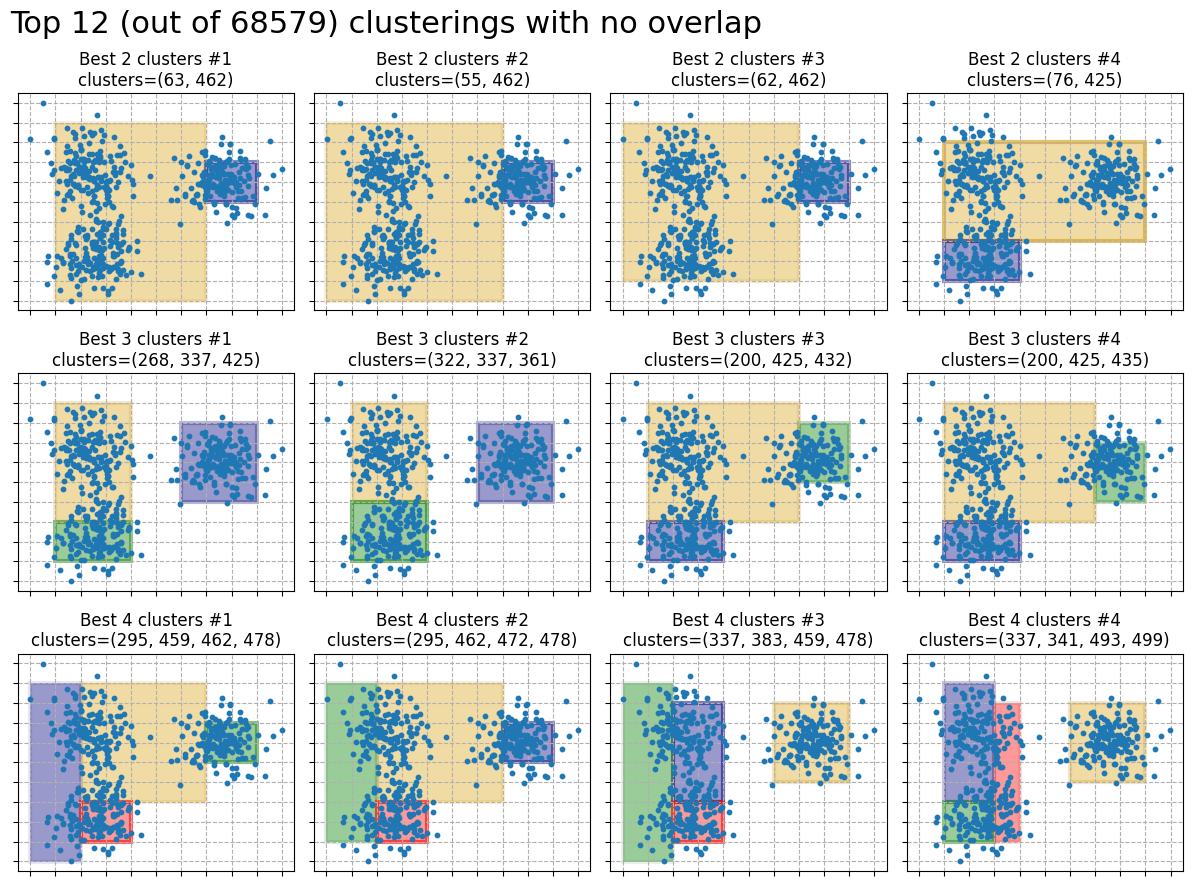

In [21]:
fig, axs = plt.subplots(clusterings_df['size'].max()-1, 4, figsize=(12, 9))

for row_idx, n_clusters in enumerate(range(2, clusterings_df['size'].max()+1)):
    flg = (clusterings_df['size']==n_clusters)&(clusterings_df['overlap']==0)
    best_clusterings = clusterings_df[flg]
    
    for i, (ax, best_clustering) in enumerate(zip(axs[row_idx], best_clusterings.index)):
        vlib.init_axis(ax, f"Best {n_clusters} clusters #{i+1}\nclusters={best_clusterings.index[i]}", 
                       linscale_x, linscale_y, [], [],#range(len(linscale_x)), range(len(linscale_y)), 
                       grid_params=dict(zorder=0, linestyle='--'))

        ax.scatter(X[:,0], X[:,1], zorder=2, s=10)
        vlib.draw_clustering(ax, best_clustering, concepts_df)

fig.suptitle(f'Top {len(axs.flatten())} (out of {len(clusterings_df)}) clusterings with no overlap',
             size=22, ha='left', x=0.01)
fig.tight_layout()
fig.subplots_adjust()
# ax.legend(loc='lower right')
fig.savefig('../figures/best_clusters_per_size_blops.pdf')
plt.show()